Prophet

c:\Kenil Ramani\QB\myvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


--- First 5 Rows of the Dataset ---
          ds    y
0 1949-01-01  112
1 1949-02-01  118
2 1949-03-01  132
3 1949-04-01  129
4 1949-05-01  121




10:20:30 - cmdstanpy - INFO - Chain [1] start processing
10:20:30 - cmdstanpy - INFO - Chain [1] done processing


--- Last 5 Rows of the Future DataFrame ---
            ds
163 1962-08-01
164 1962-09-01
165 1962-10-01
166 1962-11-01
167 1962-12-01


--- Sample of Forecasted Values ---
            ds        yhat  yhat_lower  yhat_upper
163 1962-08-01  702.601429  688.193835  717.921681
164 1962-09-01  596.169887  581.121651  610.427140
165 1962-10-01  523.064615  508.665148  538.687076
166 1962-11-01  455.368280  440.653107  468.908060
167 1962-12-01  508.631672  493.701491  523.407242

--- Plotting the Forecast ---


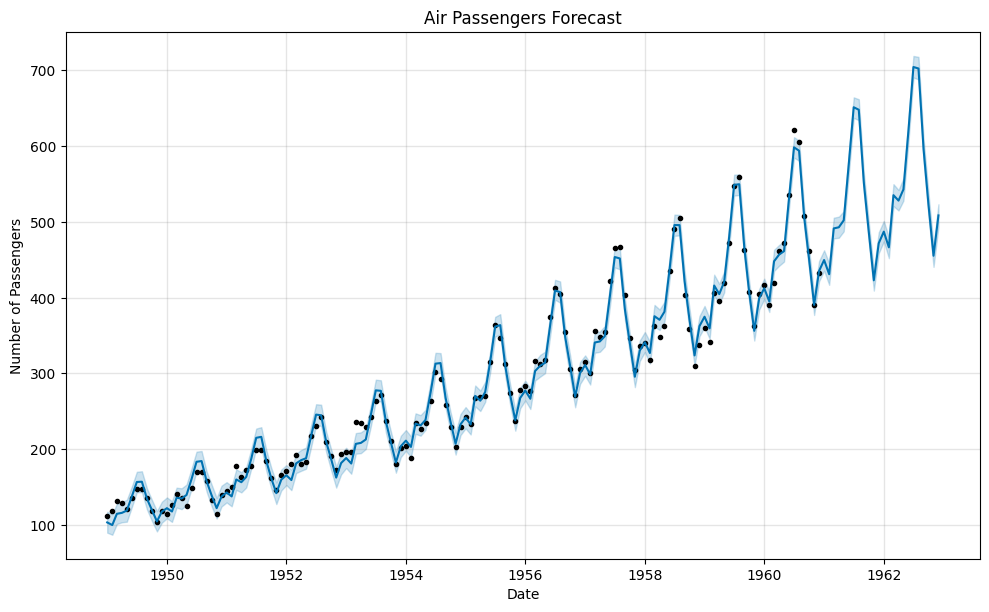

****


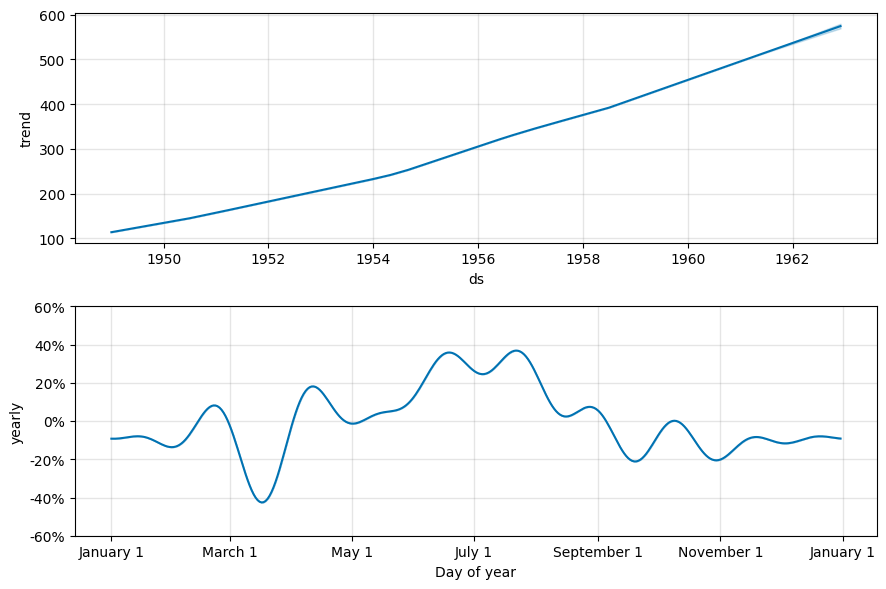

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Step 1: Load and Prepare the Dataset
# We'll use a dataset that's readily available online.
url = 'https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv'
df = pd.read_csv(url)

# Prophet requires the columns to be named 'ds' (for the datestamp) and 'y' (for the value).
# The 'ds' column should be a datetime format.
df['ds'] = pd.to_datetime(df['ds'])

print("--- First 5 Rows of the Dataset ---")
print(df.head())
print("\n")


# Step 2: Initialize and Fit the Prophet Model
# This is the "training" step. Prophet is fitting its trend and seasonality components.
# We are using multiplicative seasonality because the seasonal effect grows with the trend.
model = Prophet(seasonality_mode='multiplicative')                                                  # by default, seasonality_mode='additive'
model.fit(df)


# Step 3: Create a Future DataFrame for Predictions
# We want to forecast for the next 2 years (24 months).
future = model.make_future_dataframe(periods=24, freq='MS') # 'MS' for Month Start

print("--- Last 5 Rows of the Future DataFrame ---")
print(future.tail())
print("\n")


# Step 4: Generate the Forecast
# The predict method uses the fitted model to make predictions for the future dates.
forecast = model.predict(future)

print("--- Sample of Forecasted Values ---")
# The forecast dataframe contains many columns, but 'yhat' is the prediction.
# 'yhat_lower' and 'yhat_upper' form the uncertainty interval.
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


# Step 5: Visualize the Forecast
# Prophet has a built-in plotting function that makes it easy to see the results.
print("\n--- Plotting the Forecast ---")
fig = model.plot(forecast)
plt.title('Air Passengers Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()

# You can also visualize the individual components of the forecast.
fig2 = model.plot_components(forecast)
plt.show()

LightGBM

--- Original Data Head ---
        date  passengers
0 1949-01-01         112
1 1949-02-01         118
2 1949-03-01         132
3 1949-04-01         129
4 1949-05-01         121


--- Data with Engineered Features ---
        date  passengers  month  year  dayofweek  quarter  weekofyear  lag_12
0 1950-01-01         115      1  1950          6        1          52   112.0
1 1950-02-01         126      2  1950          2        1           5   118.0
2 1950-03-01         141      3  1950          2        1           9   132.0
3 1950-04-01         135      4  1950          5        2          13   129.0
4 1950-05-01         125      5  1950          0        2          18   121.0


--- Training LightGBM Model ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Numbe

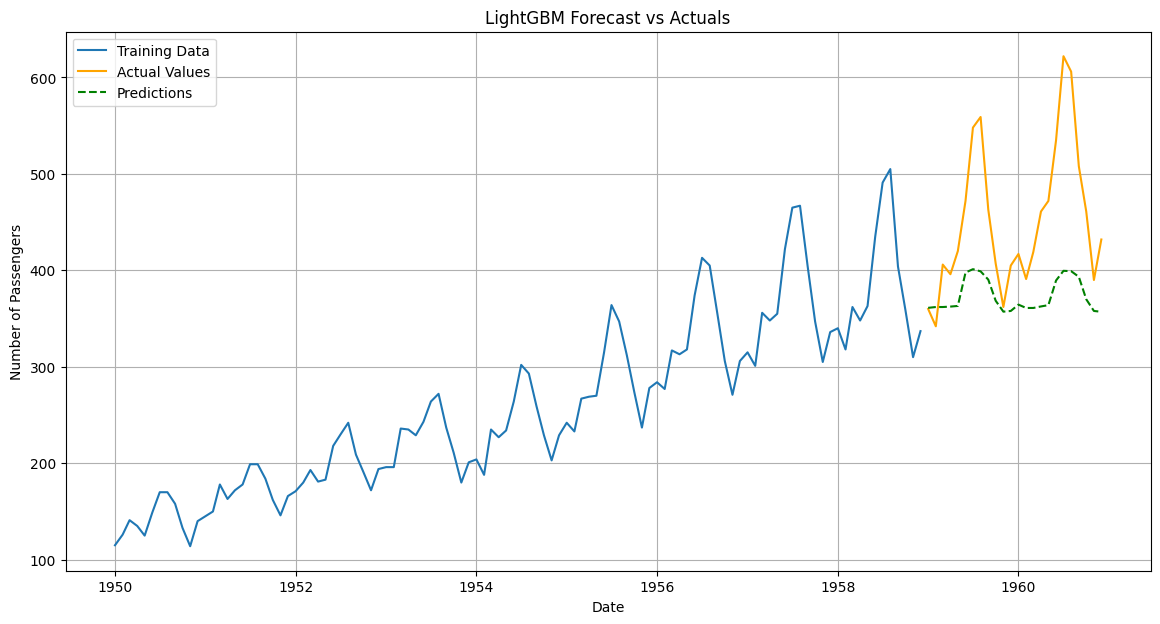

In [2]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load and Prepare the Dataset
url = 'https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv'
df = pd.read_csv(url, parse_dates=['ds'])
df.rename(columns={'ds': 'date', 'y': 'passengers'}, inplace=True)

print("--- Original Data Head ---")
print(df.head())
print("\n")

# Step 2: Feature Engineering
# This is the most crucial step for using tree-based models for forecasting.
def create_features(df):
    """
    Creates time series features from a datetime index.
    """
    df_new = df.copy()
    df_new['month'] = df['date'].dt.month
    df_new['year'] = df['date'].dt.year
    df_new['dayofweek'] = df['date'].dt.dayofweek
    df_new['quarter'] = df['date'].dt.quarter
    df_new['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    
    # Lag features - using past values to predict future ones
    # We will use the value from 12 months ago to help predict the current month
    df_new['lag_12'] = df_new['passengers'].shift(12)
    
    return df_new

df_featured = create_features(df)

# Drop rows with NaN values created by lag features
df_featured = df_featured.dropna().reset_index(drop=True)

print("--- Data with Engineered Features ---")
print(df_featured.head())
print("\n")


# Step 3: Split Data into Training and Testing Sets
# We will use the last 2 years (24 months) as our test set
split_point = len(df_featured) - 24
train = df_featured.iloc[:split_point]
test = df_featured.iloc[split_point:]

# Define our features (X) and target (y)
FEATURES = ['month', 'year', 'dayofweek', 'quarter', 'weekofyear', 'lag_12']
TARGET = 'passengers'

X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]


# Step 4: Initialize and Train the LightGBM Model
# This is a standard regression model setup.
lgbm = lgb.LGBMRegressor(
    objective='regression_l1', # MAE
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("--- Training LightGBM Model ---")
lgbm.fit(X_train, y_train,
         eval_set=[(X_test, y_test)],
         eval_metric='rmse',
         callbacks=[lgb.early_stopping(100, verbose=True)])
print("\n")

# Step 5: Make Predictions on the Test Set
predictions = lgbm.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"--- Model Evaluation ---")
print(f"Test Set RMSE: {rmse:.2f}\n")


# Step 6: Visualize the Forecast
# Create a dataframe to easily plot the results
test_results = pd.DataFrame({
    'date': test['date'],
    'actuals': y_test,
    'predictions': predictions
})

plt.figure(figsize=(14, 7))
plt.plot(train['date'], train['passengers'], label='Training Data')
plt.plot(test_results['date'], test_results['actuals'], label='Actual Values', color='orange')
plt.plot(test_results['date'], test_results['predictions'], label='Predictions', color='green', linestyle='--')
plt.title('LightGBM Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()